# MIC - Colony Detection

Bacteria streaked onto 6-well agar plates in which each well contained a different dilution of ampicillin. MIC was determined as a binary readout of the ampicillin concentration at which no bacteria grew.

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
GROWTH_CURVES_DIR = LOCAL_DIR+'/figures/growth_curves'
OUTPUT_DIR = GROWTH_CURVES_DIR+'/mic_colony_detection'
if not os.path.exists(GROWTH_CURVES_DIR): os.makedirs(GROWTH_CURVES_DIR)
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

RAW_DATA_SHEETNAME = 'growth_miccolony'

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
df = FHS.add_manuscript_name_to_df(
    pd.read_excel(
        FHS.get_data_filename(), 
        sheet_name=RAW_DATA_SHEETNAME
    ), 
    synonym_column='Sample ID',
    new_column='manuscript_name'
)

df = df[df['Sample ID'] != 'Untransformed DH5a'] #remove zeocin control

df['mean'] = df.apply(
    lambda row: np.mean([row['Rep 1 MIC'], row['Rep 2 MIC'], row['Rep 3 MIC']]),
    axis=1
)
df['stdev'] = df.apply(
    lambda row: np.std([row['Rep 1 MIC'], row['Rep 2 MIC'], row['Rep 3 MIC']]),
    axis=1
)

sample_order = FHS.get_sample_order(df.manuscript_name)
df = df.assign(
    order = lambda tmpdf: tmpdf['Sample ID'].apply(
        lambda s: sample_order.index(s)
    )
).sort_values(by='order')

## Plot Figures

In [5]:
def plot_final(save_fig=False, hide_labels=False):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(8, 3)

    #plot final call
    #without this bottom annotation, a saved pdf output is an infinite clipped bar
    #https://stackoverflow.com/questions/66158950/exporting-pyplot-historgram-to-illustrator-has-infinite-bars
    bottom = 2 
    bp = ax.bar(
        df['manuscript_name'], 
        df['mean'] - bottom,
        color='lightgray',
        bottom=bottom
    )
    
    #plot raw datapoints, but "smart" jitter so all are visible
    rawdatapoints = {'x':[], 'y': []}
    for idx, samplename in enumerate(sample_order):
        bar_details = bp.patches[idx]
        padding = 0.2 * bar_details.get_width()
        bar_x_start = bar_details.xy[0] + padding
        bar_width = bar_details.get_width() - (2 * padding)
        
        tmp_df = df[df.manuscript_name==samplename]
        rep_spacing = 1 / 2 * bar_width
        rawdatapoints['x'].append(bar_x_start)
        rawdatapoints['x'].append(bar_x_start + (1 * rep_spacing))
        rawdatapoints['x'].append(bar_x_start + (2 * rep_spacing))
        rawdatapoints['y'].append(tmp_df['Rep 1 MIC'])
        rawdatapoints['y'].append(tmp_df['Rep 2 MIC'])
        rawdatapoints['y'].append(tmp_df['Rep 3 MIC'])
    ax.scatter(
        x=rawdatapoints['x'], y=rawdatapoints['y'], 
        color='darkred', s=10, zorder=10,
        marker='D', linewidth=0
    )

    #add text values to result
    for idx, samplename in enumerate(sample_order):
        bar_details = bp.patches[idx]
        val = list(df[df.manuscript_name==samplename]['mean'])[0]
        if val % 1 == 0: val = int(val)
        ax.text(
            x=bar_details.xy[0] + (bar_details.get_width() / 2), 
            y=3, #hard code
            horizontalalignment='center', verticalalignment='top',
            s='{0}'.format(val),
            fontsize=8
        )

    #set text
    ax.set_title('Colony Minimum Inhibitory Concentraiton (MIC):\n'\
                 '(concentration of Ampicillin at which no colonies formed)', fontsize=14)
    ax.set_ylabel('Minimum Inhibitory Concentration (MIC)\n of Ampicillin (ug/mL)')
    ax.set_xlabel('design')
    ax.set_yscale('log', base=2)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylim([2, ax.get_ylim()[1]])

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        
    if hide_labels:
        ax.title.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.set_yticklabels([])
        ax.xaxis.label.set_visible(False)
        ax.set_xticklabels([])
        
    if save_fig: 
        fig.savefig(OUTPUT_DIR+'/colonymic_AMP.pdf')

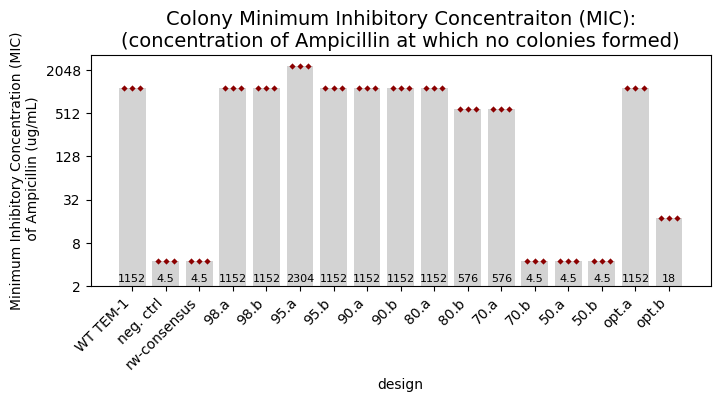

In [6]:
plot_final(save_fig=False, hide_labels=False)

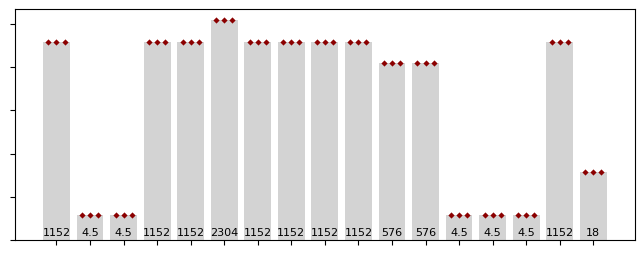

In [7]:
#output for actual PDF - to standardize exact sizing and add labels etc later
plot_final(save_fig=True, hide_labels=True)